# **Cryptocurrency Price Prediction with LSTM**

*Student ID*: **20120454**

*Name*: **Lê Công Đắt**

> BTC-USD, ETH-USD, ADA-USD

### Connect to Google Drive

In [1]:
# Kết nối Google drive để lưu tài nguyên
from google.colab import drive
drive.mount('/content/drive')

# Chuyển đến thư mục
%cd /content/drive/My Drive/Individual AI Project/crypto

Mounted at /content/drive
/content/drive/My Drive/Individual AI Project/crypto


### Import libraries

In [2]:
!pip install tensorflow==2.16.1
!pip install keras==3.3.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 983.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 33.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    

In [3]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

2.16.1
3.3.3


In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input


from sklearn.preprocessing import MinMaxScaler

from datetime import datetime
import time
from datetime import timedelta
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

from keras.models import load_model

import yfinance as yf

### Get Stock data of BTC-USD (Bitcoin)

In [13]:
class YahooDailyReader():
    def __init__(self, symbol=None, start=None, end=None):
        """
        Khởi tạo YahooDailyReader với mã chứng khoán và khoảng thời gian.

        Tham số:
        symbol (str): Mã cổ phiếu, ví dụ: 'AAPL' cho Apple.
        start (datetime): Ngày bắt đầu để lấy dữ liệu lịch sử.
        end (datetime): Ngày kết thúc để lấy dữ liệu lịch sử.
        """

        self.symbol = symbol
        self.start = start
        self.end = end

        # Chuyển đổi ngày bắt đầu và ngày kết thúc sang định dạng Unix timestamp.
        unix_start = int(time.mktime(self.start.timetuple()))
        day_end = self.end.replace(hour=23, minute=59, second=59)
        unix_end = int(time.mktime(day_end.timetuple()))

    def read(self):
        """
        Lấy và phân tích dữ liệu lịch sử từ Yahoo Finance.

        Trả về:
        pandas.DataFrame: Một DataFrame chứa dữ liệu giá lịch sử.
        """

        # Lấy dữ liệu từ Yahoo Finance.
        stock_data = yf.download(self.symbol, start=self.start, end=self.end, interval='1d')

        # Chuyển đổi dữ liệu JSON thành một pandas DataFrame.
        df = pd.DataFrame(stock_data).reset_index()

         # Thêm mã cổ phiếu như một cột trong DataFrame.
        df.insert(1, 'symbolid', self.symbol)

        # Chuyển đổi Unix timestamps thành date objects.
        df['Date'] = pd.to_datetime(df['Date'], unit='s').dt.date

        # Loại bỏ các hàng mà giá 'Close' là NaN.
        df = df.dropna(subset=['Close'])

        # Đổi tên các cột.
        colnames = ['Date', 'symbolid', 'Close', 'Open', 'High', 'Low', 'AdjClose', 'Volume']
        df.columns = colnames

        # Đặt cột 'Date' làm index.
        df = df.set_index('Date')

        return df

In [14]:
symbol = 'BTC-USD'
start = datetime(1990, 1, 1)
end = datetime(2024, 6, 20)
reader = YahooDailyReader(symbol=symbol, start=start, end=end)
df = reader.read()
df.to_csv(f'csvdata/{symbol}.csv')
df.shape

[*********************100%%**********************]  1 of 1 completed


(3564, 7)

### Read the dataset

In [15]:
df=pd.read_csv(f'csvdata/{symbol}.csv')
df.head()

,Date,symbolid,Close,Open,High,Low,AdjClose,Volume
0,2014-09-17,BTC-USD,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,BTC-USD,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,BTC-USD,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,BTC-USD,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,BTC-USD,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


### Analyze the closing prices from dataframe

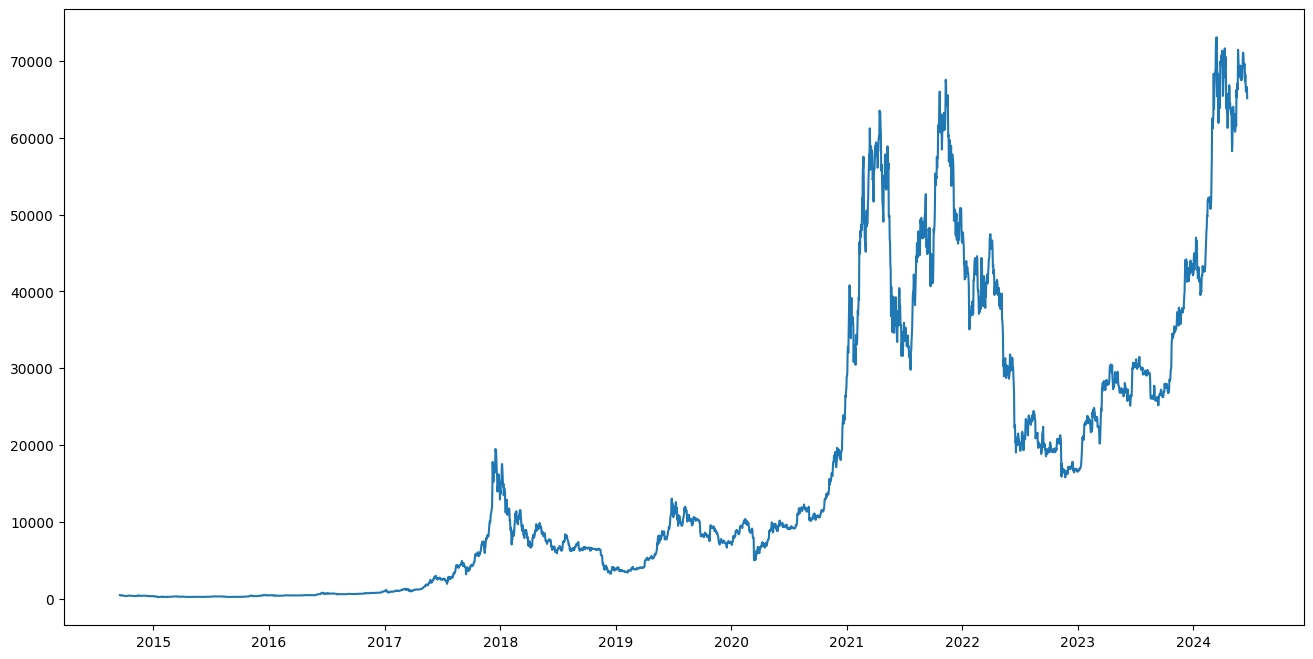

In [16]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

### Sort the dataset on date time and filter “Date” and “Close” columns

In [17]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

new_dataset.tail()

,Date,Close
3559,2024-06-15 00:00:00,66006.742188
3560,2024-06-16 00:00:00,66189.359375
3561,2024-06-17 00:00:00,66636.515625
3562,2024-06-18 00:00:00,66490.976562
3563,2024-06-19 00:00:00,65146.660156


### Normalize the new filtered dataset

In [18]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

train_size = int(len(final_dataset) * 0.8)
train_data = final_dataset[:train_size, :]
valid_data = final_dataset[train_size:, :]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))


### Build and train the LSTM model

In [37]:

# Build and train the LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(x_train_data.shape[1], 1)))
lstm_model.add(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.01)))  # Add L2 regularization
lstm_model.add(Dropout(0.2))  # Increase dropout
lstm_model.add(LSTM(units=50, kernel_regularizer=l2(0.01)))  # Add L2 regularization
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics = ["accuracy"])

# Add EarlyStopping to avoid overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

validation_split = 0.2
history = lstm_model.fit(x_train_data, y_train_data, epochs=100, batch_size=64, verbose=2, validation_split=validation_split) # callbacks=[early_stopping]

Epoch 1/100
35/35 - 7s - 197ms/step - accuracy: 4.4803e-04 - loss: 0.5973 - val_accuracy: 0.0000e+00 - val_loss: 0.4032
Epoch 2/100
35/35 - 2s - 69ms/step - accuracy: 4.4803e-04 - loss: 0.2772 - val_accuracy: 0.0000e+00 - val_loss: 0.1862
Epoch 3/100
35/35 - 4s - 113ms/step - accuracy: 4.4803e-04 - loss: 0.1204 - val_accuracy: 0.0000e+00 - val_loss: 0.1160
Epoch 4/100
35/35 - 4s - 104ms/step - accuracy: 4.4803e-04 - loss: 0.0492 - val_accuracy: 0.0000e+00 - val_loss: 0.0459
Epoch 5/100
35/35 - 2s - 69ms/step - accuracy: 4.4803e-04 - loss: 0.0189 - val_accuracy: 0.0000e+00 - val_loss: 0.0398
Epoch 6/100
35/35 - 3s - 72ms/step - accuracy: 4.4803e-04 - loss: 0.0071 - val_accuracy: 0.0000e+00 - val_loss: 0.0214
Epoch 7/100
35/35 - 3s - 76ms/step - accuracy: 4.4803e-04 - loss: 0.0028 - val_accuracy: 0.0000e+00 - val_loss: 0.0678
Epoch 8/100
35/35 - 5s - 137ms/step - accuracy: 4.4803e-04 - loss: 0.0014 - val_accuracy: 0.0000e+00 - val_loss: 0.1139
Epoch 9/100
35/35 - 3s - 74ms/step - accurac

### Take a sample of a dataset to make stock price predictions using the LSTM model

In [38]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)


X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


### Save the LSTM model

In [39]:
lstm_model.save("saved_model.keras")
lstm_model.save("saved_model.h5")
lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

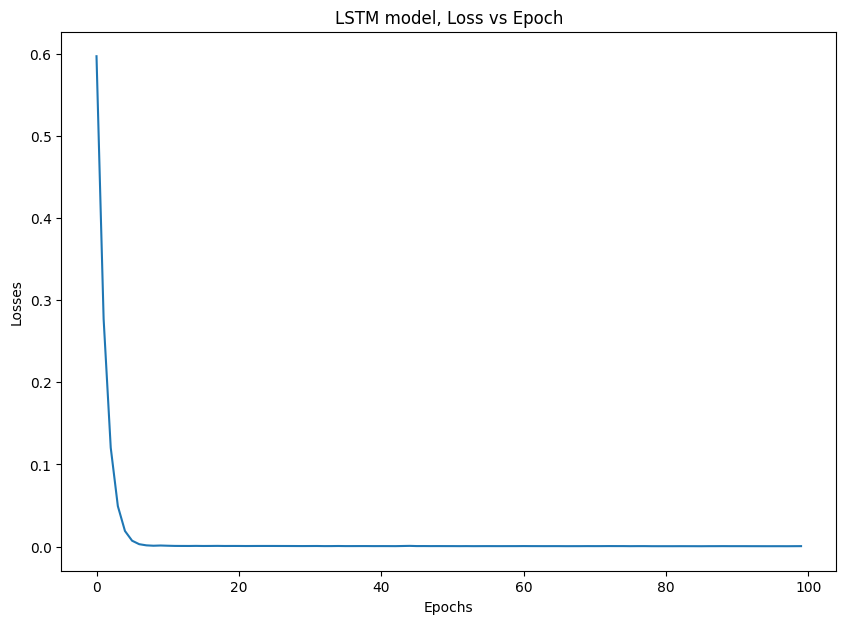

In [40]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Loss vs Epoch")
plt.show()

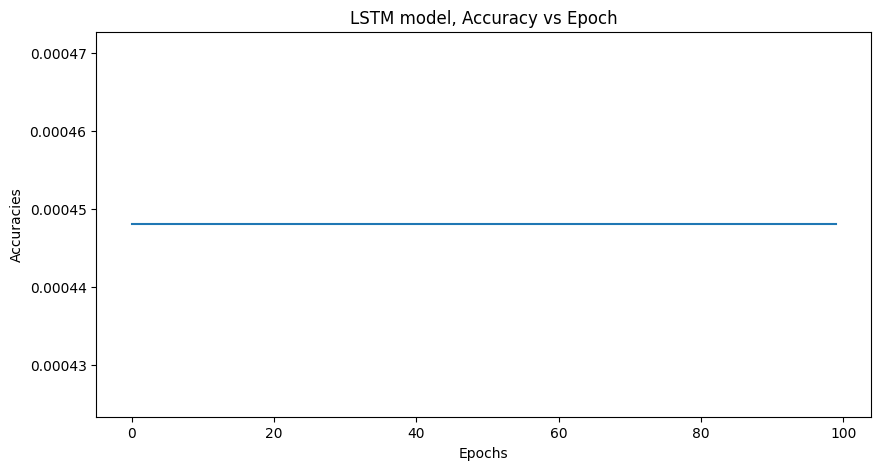

In [41]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("LSTM model, Accuracy vs Epoch")
plt.show()

### Visualize the predicted cryptocurrency costs with actual cryptocurrency costs

<ipython-input-42-5c9ca86cff4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


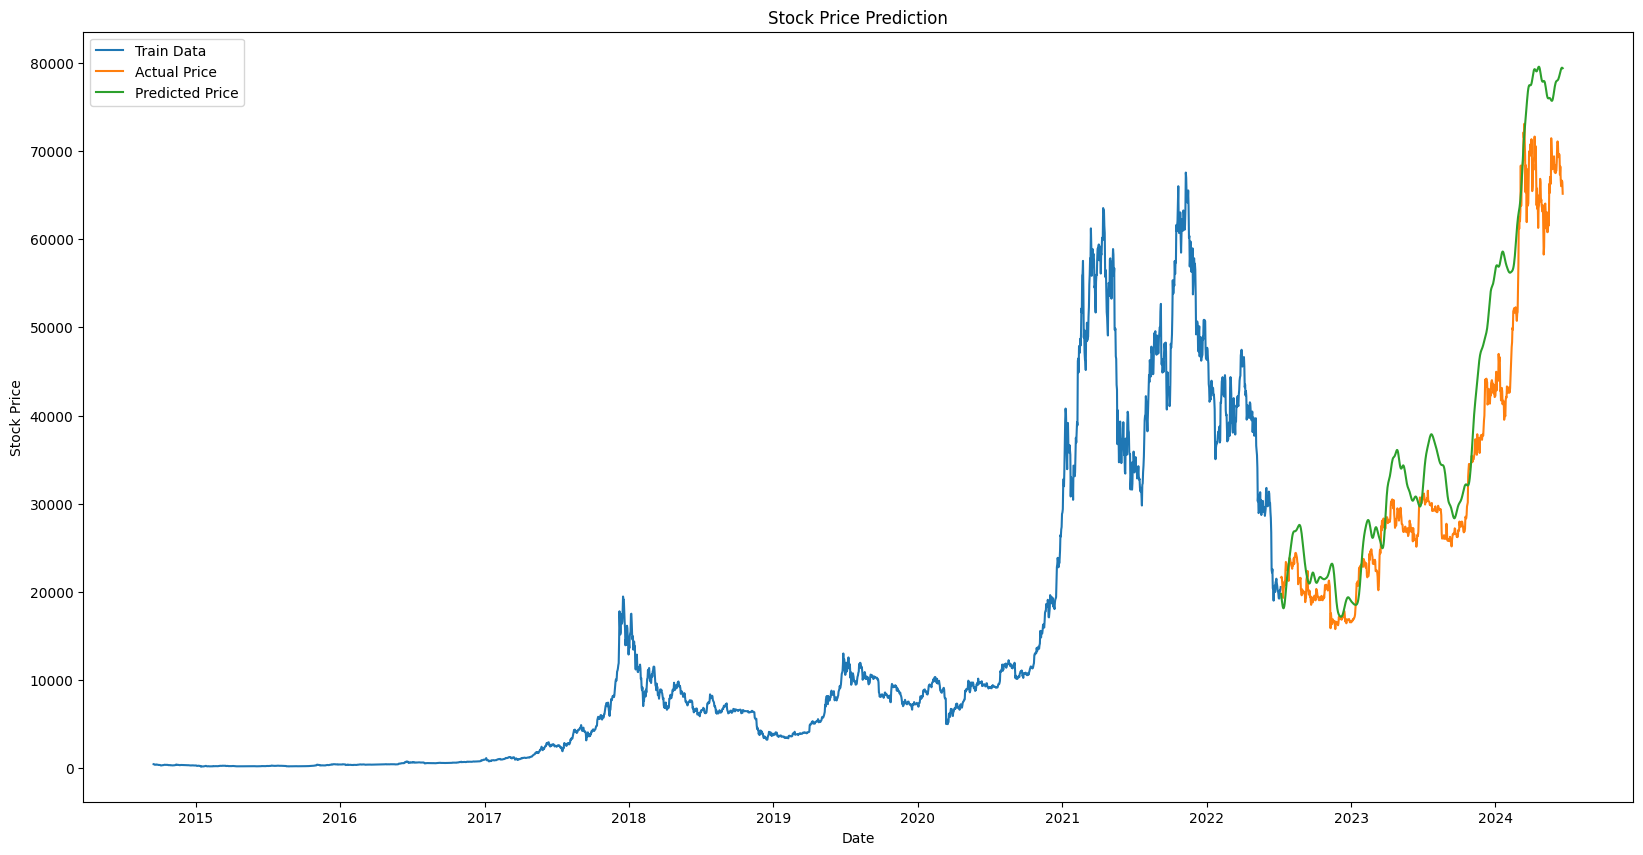

In [42]:
train_data=new_dataset[:train_size]
valid_data=new_dataset[train_size:]
valid_data['Predictions']=predicted_closing_price

plt.plot(train_data["Close"], label='Train Data')
plt.plot(valid_data["Close"], label='Actual Price')
plt.plot(valid_data["Predictions"], label='Predicted Price')

plt.legend()

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.show()

### Visualize the predicted stock costs in future

In [43]:
# Make future predictions until December 2025
future_dates = pd.date_range(start=df['Date'].max() + timedelta(days=1), end='2025-12-31', freq='B')
future_predictions = []

# Start with the last 60 days of data
last_60_days = scaled_data[-60:].reshape(1, 60, 1)

for date in future_dates:
    predicted_price = lstm_model.predict(last_60_days)
    future_predictions.append(predicted_price[0, 0])
    # Add the predicted price to the input data and maintain the shape
    predicted_price_reshaped = predicted_price.reshape(1, 1, 1)
    last_60_days = np.append(last_60_days[:, 1:, :], predicted_price_reshaped, axis=1)

# Inverse transform the predictions to get actual prices
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions)

# Create a DataFrame for future predictions
future_df = pd.DataFrame({'Date': future_dates, 'Predictions': future_predictions.flatten()})
future_df.set_index('Date', inplace=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

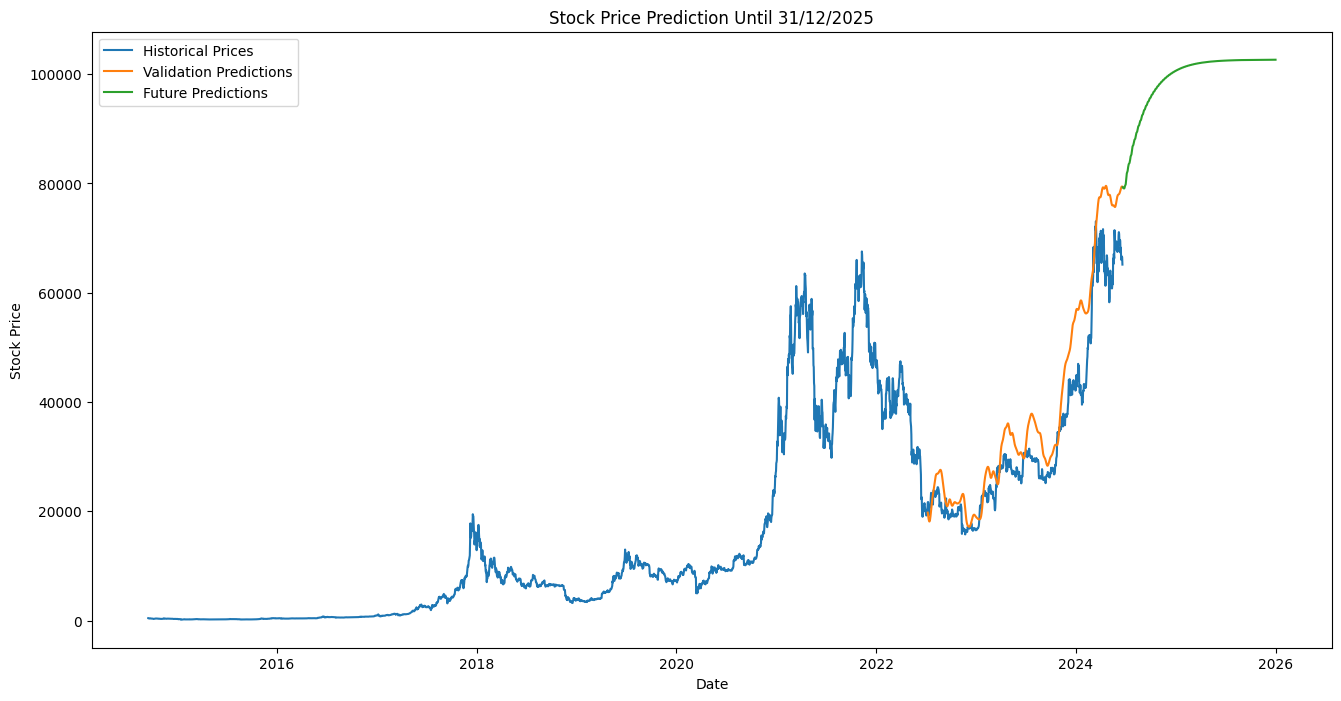

In [44]:
# Plot the future predictions
plt.figure(figsize=(16, 8))
plt.plot(df["Close"], label='Historical Prices')
plt.plot(valid_data['Predictions'], label='Validation Predictions')
plt.plot(future_df['Predictions'], label='Future Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction Until 31/12/2025')
plt.show()